In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.train as smp_train
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


In [ ]:
# 今回の学習で必要になる処理を入れたDataset
class MyDataset(Dataset):
    def __init__(self, imgs, masks, transform):
        """
        imgs : 画像が入ったlist
        masks : 正解マスクが入ったlist
        transform : 画像やマスクに前処理を行う関数
        """
        self.imgs = imgs
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    # 処理を行う部分
    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = (self.masks[idx] > 0).astype(float)

        # 画像とマスクに前処理を実施
        sample = self.transform(image=img, mask=mask)
        img, mask = sample['image'], sample['mask']

        return img, mask[np.newaxis] # maskは3チャンネルである必要あり（class, H, W）


In [ ]:
# 前処理の定義
# Composeを使用すると複数の処理を一気に行うことができる

# 訓練用
train_transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(), #numpy arrayをpytorchで使用するTensorに変換
])

# 推論用
val_transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
# data loaderを作成する関数
def make_dataloader(imgs, masks, transforms, batch_size, shuffle=True):
    dataset = MyDataset(imgs, masks, transforms)
    loader = DataLoader(dataset, batch_size=batch_size,
                        drop_last=False, shuffle=shuffle, num_workers=2)

    return loader

# 学習に使用するモデル類を作成する関数
def make_model(device):
    model = smp.Unet(
        encoder_name="tu-efficientnet_b0", #timmのモデルを使う際は先頭にtu-をつける
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        encoder_depth=5,
    )

    # 損失関数
    loss = nn.BCEWithLogitsLoss()
    loss.__name__ = "bce_loss"

    # 評価関数（今回はIoUを使用）
    metrics = [
        smp_metrics.IoU(threshold=0.5, activation="sigmoid"),
    ]

    # 最適化関数（今回はAdamを使用）
    optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

    # smpに用意されているシンプルなループ用クラス（train用）
    train_epoch = smp_train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=device,
        verbose=True,
    )

    # smpに用意されているシンプルなループ用クラス（valid用）
    valid_epoch = smp_train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=device,
        verbose=True,
    )

    return model, train_epoch, valid_epoch

In [ ]:
# テストデータの評価時に使用するループ処理を行う関数
def test_loop(model, data_loader, metric, device):
    """
    model : 学習済みのモデル
    data_loader : テストのデータローダー
    metric : 評価関数（今回はIoU）
    device : GPU or CPU
    """

    metric_list = [] # テスト画像のIoUの結果を保持するためのリスト
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(x)

        # IoU計算
        metric_value = metric(y_pred, y).cpu().detach().numpy()
        metric_list.append(float(metric_value))

    return metric_list

In [ ]:
img_path = sorted(glob("/content/drive/MyDrive/止まれセグメンテーション/dataset/image/*.jpg"))
img = [cv2.imread(i)[..., [2,1,0]] for i in img_path] # BGR→RGBで読み込み

mask_path = sorted(glob("/content/drive/MyDrive/止まれセグメンテーション/dataset/mask/*.png"))
mask = [cv2.imread(i, 0) for i in mask_path]

num_tomare = len(img_path) // 3 # 「止まれ」の組数
idxes = list(range(num_tomare)) # 分割に使用するため事前にインデックスのリストを用意


In [ ]:
# fold数は6
n_splits = 6

# 「止まれ」の組を6等分する
fold_idxes = []
for i in range(n_splits):
    fold = [idxes[j] for j in range(i, num_tomare, n_splits)]
    fold_idxes.append(fold)
fold_idxes

[[0, 6, 12, 18, 24],
 [1, 7, 13, 19, 25],
 [2, 8, 14, 20, 26],
 [3, 9, 15, 21, 27],
 [4, 10, 16, 22, 28],
 [5, 11, 17, 23, 29]]

In [ ]:
# 全ての分割が評価に使用されるように順繰りにしたインデックスを用意
folds = [[i%n_splits for i in range(j, j+n_splits)] for j in range(n_splits)]
folds

[[0, 1, 2, 3, 4, 5],
 [1, 2, 3, 4, 5, 0],
 [2, 3, 4, 5, 0, 1],
 [3, 4, 5, 0, 1, 2],
 [4, 5, 0, 1, 2, 3],
 [5, 0, 1, 2, 3, 4]]

fold 0 は folds[0]を使用し、fold_idxes[[0,1,2,3]]の「止まれ」を学習に、fold_idxes[4]をvalidationに、fold_idxes[5]をテストに使用する。

同様に、
fold 1 は folds[1]を使用し、fold_idxes[[1,2,3,4]]の「止まれ」を学習に、fold_idxes[5]をvalidationに、fold_idxes[0]をテストに使用する。

これをfold 0 〜 5の6回行う。

In [ ]:
# バッチサイズは5
batch_size = 5
# 学習epoch数
n_epoch = 20

# 使用デバイスの設定（今回はcudaが設定される）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_iou_list = [] # 各foldで行われたテストの評価結果を保持

# 順番にfoldの学習・評価を行う
for enum, fold in enumerate(folds):
    print(f"fold : {enum+1}")

    train_img, train_mask = [], []

    # foldのリストの最初の4つは訓練データ
    for f in fold[:4]:
        img_tmp = [img[i*3 + j] for i in fold_idxes[f] for j in range(3)]
        mask_tmp = [mask[i*3 + j] for i in fold_idxes[f] for j in range(3)]

        train_img += img_tmp
        train_mask += mask_tmp

    # 5番目はvalid
    valid_img = [img[i*3 + j] for i in fold_idxes[fold[-2]] for j in range(3)]
    valid_mask = [mask[i*3 + j] for i in fold_idxes[fold[-2]] for j in range(3)]
    # 6番目はtest
    test_img = [img[i*3 + j] for i in fold_idxes[fold[-1]] for j in range(3)]
    test_mask = [mask[i*3 + j] for i in fold_idxes[fold[-1]] for j in range(3)]

    # data loaderを作成
    train_loader = make_dataloader(train_img, train_mask, train_transform,
                                   batch_size, True)
    valid_loader = make_dataloader(valid_img, valid_mask, val_transform,
                                   batch_size, False)
    test_loader = make_dataloader(test_img, test_mask, val_transform,
                                  1, False) # テストの評価はbatch_sizeを1に

    model, train_epoch, valid_epoch = make_model(device)

    # 学習ループの実行
    max_score = 0 # ベストのスコアを保持する用
    # モデルの保存名(適宜名前を変えてください)
    model_save_path = f"/content/drive/MyDrive/止まれセグメンテーション/best_model_{enum}.pth"

    # n_epoch分学習ループを回す
    for e in range(0, n_epoch):
        print(f'Epoch: {e+1}')

        # 学習
        _ = train_epoch.run(train_loader)

        # 評価
        valid_logs = valid_epoch.run(valid_loader)

        # もしvalidのIoUスコアが今までの最大値よりも大きかったらモデルの保存
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model.state_dict(), model_save_path)
            print('Model saved!')

    # 保存したモデルの重みをロード
    model.load_state_dict(torch.load(model_save_path, map_location='cpu'))
    model.eval() # 評価用モードに変更

    # テスト評価
    iou = smp_metrics.IoU(threshold=0.5, activation="sigmoid")
    test_iou = test_loop(model, test_loader, iou, device)

    print(np.mean(test_iou))
    test_iou_list.append(test_iou)

In [ ]:
# IoUの平均をみる
print(np.array(test_iou_list).mean())

Text(0, 0.5, 'IoU')

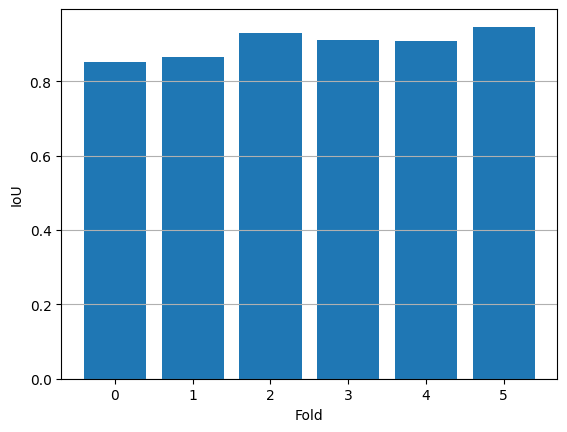

In [ ]:
# 各FoldでのIoUの結果を可視化

plt.bar(list(range(n_splits)),
        [np.mean(test_iou_list[i]) for i in range(n_splits)])
plt.rcParams['axes.axisbelow'] = True
plt.grid(which="major", linestyle="-", axis="y")
plt.xlabel("Fold")
plt.ylabel("IoU")

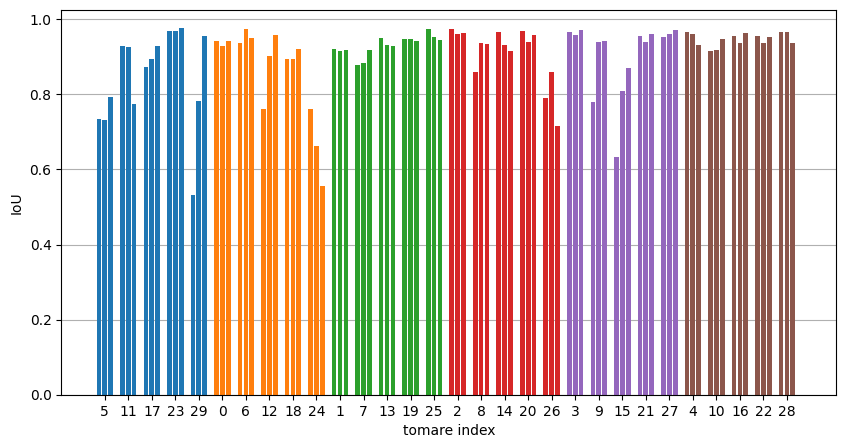

In [ ]:
# 画像ごとのIoUを可視化

plt.figure(figsize=[10,5]) # 棒グラフのサイズを定義
xticks = [] # 「止まれ」のインデックスを保存しておくためのlist

# 各foldのテストセットの塊ごとにIoUの結果を表示
for enum, fold in enumerate(folds):
    test_idx = [i*3 + j for i in fold_idxes[fold[-1]] for j in range(3)]
    xticks += fold_idxes[fold[-1]]

    # グラフを見やすくするために、「止まれ」毎に0を入れて擬似的に隙間を開ける
    test_iou_list_ = []
    for i in range(len(test_iou_list[enum])):
        test_iou_list_.append(test_iou_list[enum][i])
        # 0を入れる
        if (i+1) % 3 == 0:
            test_iou_list_.append(0)
    # 棒グラフ描画
    plt.bar([i+20*enum for i in range(len(test_iou_list_))], test_iou_list_)

# 見やすくするために色々と設定
plt.rcParams['axes.axisbelow'] = True
plt.grid(which="major", linestyle="-", axis="y")
plt.xticks(list(range(1, len(xticks)*4, 4)), xticks) # 「止まれ」のインデックスと対応させる
plt.xlabel("tomare index")
plt.ylabel("IoU")
#plt.savefig("predict_iou.png", bbox_inches="tight") # 保存用

In [ ]:
# 保存したモデルの重みをロード

fold_num = 0 # 見たいfold番号（0~5)
model_save_path = f"/content/drive/MyDrive/止まれセグメンテーション/best_model_{fold_num}.pth"
model.load_state_dict(torch.load(model_save_path, map_location='cpu'))
model.eval() # 評価用モードに変更

idx = 29 # 見たい「止まれ」のインデックス
sub_idx = 0 # 「止」：0、「ま」：1、「れ」：2
img_tmp = img[idx*3 + sub_idx]
mask_tmp = mask[idx*3 + sub_idx]
dataset = MyDataset([img_tmp], [mask_tmp], val_transform)

vis_img, _ = dataset[0]
vis_img = vis_img.unsqueeze(0).to(device) # モデルに入力するための処理

# 推論
with torch.no_grad():
    pred = model(vis_img)

# 推論結果をsigmoid関数に通して確率値に変換 → 確率0.5以上の部分の領域を選択
pred = (nn.Sigmoid()(pred[0, 0]) > 0.5).detach().cpu().numpy()
pred = (pred * 255).astype(np.uint8)

img_shape = img_tmp.shape
pred = cv2.resize(pred, (img_shape[1], img_shape[0])) # 元の画像サイズにリサイズ

In [ ]:
plt.figure(figsize=[6,4]) # サイズを定義
plt.subplot(131)
plt.axis("off")
plt.imshow(img_tmp)

plt.subplot(132)
plt.axis("off")
plt.imshow(mask_tmp)

plt.subplot(133)
plt.axis("off")
plt.imshow(pred)
#plt.savefig("predict_0_29.png", bbox_inches="tight") #保存用